In [1]:
%matplotlib inline

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization # how to import text vectorization in tf 2.3.0
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
import gensim
from gensim.models import Word2Vec
from keras.models import Model
from tensorflow.keras.layers import Embedding,Input,Dropout, LSTM, Bidirectional, \
    Conv1D, MaxPool1D, Dense, Attention, Flatten
from tensorflow.keras.models import Sequential

from tensorflow.keras.activations import softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping
from keras.preprocessing.text import Tokenizer


import mlflow
plt.style.use('seaborn')

## Models hyperparamters version 4

* maximum length of the sequences - we will not use the actual maximum length of the sequences as very few songs have 800 words in them. If we choose a maximum length equal to 300, we will cover 94% of the lyrics' actual length, if we choose 250 - we will cover 90%. We can try with 300, if we have a problem with the vanishing gradient - we can decrease it to 250 or even 200 (85%)



* maximum vocabulary size (word-based vocabulary) -  The set of unique words used in the text corpus is ~ 50 000. Given the fact that we work with lyrics of songs, even though we selected only English lyrics there is a high probability that there are some words left from Spanish ( typical for pop songs), some typical slang for artists, and other peculiarities. Thus we will use the maximum size of vocabulary 10 000 ( if it is too big, we can drop it to 5000) and keep only the most common words.




* BATCH_SIZE = 16
* MAX_VOCABULARY_SIZE = 5000 
* MAX_OUTPUT_LENGTH = 200
* EMBEDDING_DIMENSIONS = 100 #loaded GloVe trained  with 100d
* LEARNING_RATE = 1e-3

In [ ]:
#Vocabulary size = 5000

In [120]:
TRAIN_BASE_DIR = r"C:\Users\PC\Desktop\NN\Text calssification\train"
TEST_BASE_DIR = r"C:\Users\PC\Desktop\NN\Text calssification\test"
logs = r"C:\Users\PC\Desktop\NN\Text calssification\logs"
check_point_base = r"C:\Users\PC\Desktop\NN\Text calssification\version 4\checkpoint_base"
check_point_opt = r"C:\Users\PC\Desktop\NN\Text calssification\version 4\checkpoint_opt"
check_point_cnn = r"C:\Users\PC\Desktop\NN\Text calssification\version 4\checkpoint_cnn"

N_CLASSES = 4

BATCH_SIZE = 16 # 8
MAX_VOCABULARY_SIZE = 5000 # change to 5000 if too big
MAX_OUTPUT_LENGTH = 200 # 300
EMBEDDING_DIMENSIONS = 100 #loaded GloVe trained  with 100d
LEARNING_RATE = 1e-3 # by deafult Adam optimizer learning rate is 1e-3
Seed = 42

In [4]:

train_dataset = tf.keras.utils.text_dataset_from_directory(TRAIN_BASE_DIR,batch_size = BATCH_SIZE, validation_split=0.1,
    subset='training', seed = Seed)
   
   

Found 65048 files belonging to 4 classes.
Using 58544 files for training.


Found 65048 files belonging to 4 classes.
Using 58544 files for training.

In [5]:
print(train_dataset.cardinality().numpy())

3659


In [6]:
val_dataset = tf.keras.utils.text_dataset_from_directory(
    TRAIN_BASE_DIR, batch_size=BATCH_SIZE, validation_split=0.1,
    subset='validation', seed=Seed)

Found 65048 files belonging to 4 classes.
Using 6504 files for validation.


In [7]:
test_dataset = tf.keras.utils.text_dataset_from_directory(TEST_BASE_DIR,batch_size = BATCH_SIZE, seed = Seed)

Found 4000 files belonging to 4 classes.


In [8]:
### check the labesl
list(enumerate(train_dataset.class_names)), list(enumerate(val_dataset.class_names))

([(0, 'Jazz'), (1, 'Metal'), (2, 'Pop'), (3, 'Rock')],
 [(0, 'Jazz'), (1, 'Metal'), (2, 'Pop'), (3, 'Rock')])

In [9]:
list(enumerate(train_dataset.class_names))[1]

(1, 'Metal')

.shape method in keras gives the lenght of a sequence

## Vectorizing the text

This layer has basic options for managing text in a Keras model. It transforms a batch of strings (one sample = one string) into either a list of token indices (one sample = 1D tensor of integer token indices) or a dense representation (one sample = 1D tensor of float values representing data about the sample's tokens).

In [10]:
vectorize_layer = TextVectorization(
    max_tokens = MAX_VOCABULARY_SIZE, 
    output_sequence_length=MAX_OUTPUT_LENGTH)

In [11]:
text_ds = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [12]:
### 76952 vocabulary size without limiting the vocabulary size to max size

In [13]:
#text_ds

In [14]:
vectorize_layer.vocabulary_size()

5000

In [15]:
## 1 is unkown

In [16]:
#vectorize_layer(["something nigga money where love queen king boy girl"])

In [17]:
### test
vectorize_layer.get_vocabulary()[4000:]


['rang',
 'liberate',
 'imitation',
 'harvest',
 'frail',
 'eminem',
 'ditch',
 'crucify',
 'carter',
 'carol',
 'canvas',
 'brief',
 'yelling',
 'village',
 'stunna',
 'slut',
 'rocker',
 'relation',
 'oooo',
 'moonlit',
 'max',
 'loco',
 'league',
 'kelly',
 'incomplete',
 'grinding',
 'donna',
 'diggin',
 'decline',
 'coulda',
 'argue',
 'tuck',
 'spiral',
 'raped',
 'poster',
 'pitter',
 'marie',
 'lucifer',
 'lettin',
 'howling',
 'gyal',
 'farmer',
 'crunk',
 'countin',
 'assume',
 'aisle',
 'actor',
 'yow',
 'western',
 'upstairs',
 'twerk',
 'tipsy',
 'tic',
 'suffocate',
 'stash',
 'stairway',
 'sideways',
 'ruler',
 'rooftop',
 'retreat',
 'permanent',
 'nurse',
 'jury',
 'fu',
 'finna',
 'dreamy',
 'declare',
 'daze',
 'collapse',
 'boyz',
 'asshole',
 'worldwide',
 'wage',
 'vibration',
 'sweetness',
 'strut',
 'snatch',
 'rail',
 'purse',
 'nameless',
 'mysterious',
 'melancholy',
 'meanwhile',
 'laura',
 'jo',
 'hustlin',
 'feature',
 'coin',
 'blondie',
 'beyonce',
 'rom

In [18]:
### test 
#output = vectorize_layer([["the cat sat on the mat"]])
#output.numpy()[0, :11]


In [19]:
# Here's a dict mapping words to their indices:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
len(voc)

5000

In [20]:
list(word_index.keys())[:20]

['',
 '[UNK]',
 'im',
 'love',
 'know',
 'dont',
 'like',
 'oh',
 'get',
 'got',
 'go',
 'one',
 'time',
 'youre',
 'never',
 'see',
 'let',
 'come',
 'cant',
 'baby']

In [21]:
tf.keras.backend.clear_session()

### Load Pretrained Glove Word Embedding


#Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.


GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.


The GloVe model is trained on the non-zero entries of a global word-word co-occurrence matrix, which tabulates how frequently words co-occur with one another in a given corpus. Populating this matrix requires a single pass through the entire corpus to collect the statistics. For large corpora, this pass can be computationally expensive, but it is a one-time up-front cost. Subsequent training iterations are much faster because the number of non-zero matrix entries is typically much smaller than the total number of words in the corpus.

In [22]:
vectorize_layer.vocabulary_size()

5000

In [23]:
path_glove = (r'C:\Users\PC\Desktop\NN\NN Project\glove\glove.6B.100d.txt')

In [24]:
embeddings_index = {}
f = open(path_glove,encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [25]:
#embeddings_index

#### Creating a weight matrix for words in training docs

In [26]:
### note to self 

#index 0 is reserved for padding and index 1 is reserved for "out of vocabulary" tokens.
num_tokens = len(voc) + 2
embedding_dim = EMBEDDING_DIMENSIONS
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4925 words (75 misses)


In [27]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41711   , -0.10176   ,  0.058147  , ..., -0.29444   ,
        -0.039114  ,  0.39534   ],
       ...,
       [ 0.63734001, -0.086567  ,  0.61628997, ..., -0.22788   ,
        -0.13654999,  0.01734   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Base LSTM Model

In [86]:
tf.keras.backend.clear_session()
model_name = "base lstm model"
checkpointer = ModelCheckpoint(filepath =check_point_base,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [88]:
lstm_base_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  LSTM(64),
  Dense(N_CLASSES,activation = softmax)])

lstm_base_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = Adam(),
    metrics = ["acc"]
    )

In [89]:
lstm_base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 200, 100)          500200    
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 542,700
Trainable params: 42,500
Non-trainable params: 500,200
_________________________________________________________________


In [90]:
lstm_history_base_model = lstm_base_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 15,
          callbacks=[checkpointer, early_stopping])

Epoch 1/15
3659/3659 [==============================] - ETA: 0s - loss: 1.2162 - acc: 0.4402

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


3659/3659 [==============================] - 259s 70ms/step - loss: 1.2162 - acc: 0.4402 - val_loss: 1.0779 - val_acc: 0.5378
Epoch 2/15
3659/3659 [==============================] - ETA: 0s - loss: 1.0254 - acc: 0.5595

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


3659/3659 [==============================] - 279s 76ms/step - loss: 1.0254 - acc: 0.5595 - val_loss: 1.0330 - val_acc: 0.5600
Epoch 3/15
3659/3659 [==============================] - ETA: 0s - loss: 0.9627 - acc: 0.5960

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


3659/3659 [==============================] - 303s 83ms/step - loss: 0.9627 - acc: 0.5960 - val_loss: 0.9645 - val_acc: 0.6007
Epoch 4/15
3659/3659 [==============================] - ETA: 0s - loss: 0.9224 - acc: 0.6149

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


3659/3659 [==============================] - 296s 81ms/step - loss: 0.9224 - acc: 0.6149 - val_loss: 0.9414 - val_acc: 0.6069
Epoch 5/15
3659/3659 [==============================] - ETA: 0s - loss: 0.8898 - acc: 0.6312

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


3659/3659 [==============================] - 284s 78ms/step - loss: 0.8898 - acc: 0.6312 - val_loss: 0.9365 - val_acc: 0.6135
Epoch 6/15
3659/3659 [==============================] - ETA: 0s - loss: 0.8643 - acc: 0.6427

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


3659/3659 [==============================] - 312s 85ms/step - loss: 0.8643 - acc: 0.6427 - val_loss: 0.9413 - val_acc: 0.6136
Epoch 7/15
3659/3659 [==============================] - ETA: 0s - loss: 0.8429 - acc: 0.6522

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


3659/3659 [==============================] - 304s 83ms/step - loss: 0.8429 - acc: 0.6522 - val_loss: 0.9277 - val_acc: 0.6235
Epoch 8/15
3659/3659 [==============================] - ETA: 0s - loss: 0.8211 - acc: 0.6641

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


3659/3659 [==============================] - 298s 81ms/step - loss: 0.8211 - acc: 0.6641 - val_loss: 0.9507 - val_acc: 0.6115
Epoch 9/15
3659/3659 [==============================] - ETA: 0s - loss: 0.8021 - acc: 0.6721

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


3659/3659 [==============================] - 305s 83ms/step - loss: 0.8021 - acc: 0.6721 - val_loss: 0.9458 - val_acc: 0.6185
Epoch 10/15
3659/3659 [==============================] - ETA: 0s - loss: 0.7834 - acc: 0.6820

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


3659/3659 [==============================] - 308s 84ms/step - loss: 0.7834 - acc: 0.6820 - val_loss: 0.9595 - val_acc: 0.6102
Epoch 11/15
3659/3659 [==============================] - ETA: 0s - loss: 0.7685 - acc: 0.6891

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


3659/3659 [==============================] - 294s 80ms/step - loss: 0.7685 - acc: 0.6891 - val_loss: 0.9552 - val_acc: 0.6193
Epoch 12/15
3659/3659 [==============================] - ETA: 0s - loss: 0.7475 - acc: 0.6974

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


3659/3659 [==============================] - 299s 82ms/step - loss: 0.7475 - acc: 0.6974 - val_loss: 0.9511 - val_acc: 0.6153
Epoch 13/15
3659/3659 [==============================] - ETA: 0s - loss: 0.7335 - acc: 0.7052

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


3659/3659 [==============================] - 297s 81ms/step - loss: 0.7335 - acc: 0.7052 - val_loss: 0.9709 - val_acc: 0.6219
Epoch 14/15
3659/3659 [==============================] - ETA: 0s - loss: 0.7177 - acc: 0.7116

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


3659/3659 [==============================] - 292s 80ms/step - loss: 0.7177 - acc: 0.7116 - val_loss: 0.9811 - val_acc: 0.6172
Epoch 15/15
3659/3659 [==============================] - ETA: 0s - loss: 0.7029 - acc: 0.7171

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base\assets


3659/3659 [==============================] - 309s 84ms/step - loss: 0.7029 - acc: 0.7171 - val_loss: 0.9881 - val_acc: 0.6155


In [91]:
def plot_loss_accuracy(hist,model):
    fig=plt.figure()
    plt.plot(hist.history['acc'],'r',linewidth=3.0)
    plt.plot(hist.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title(f'Accuracy Curves : {model}',fontsize=16)
    #fig.savefig('accuracy_lstm.png')
    plt.show()

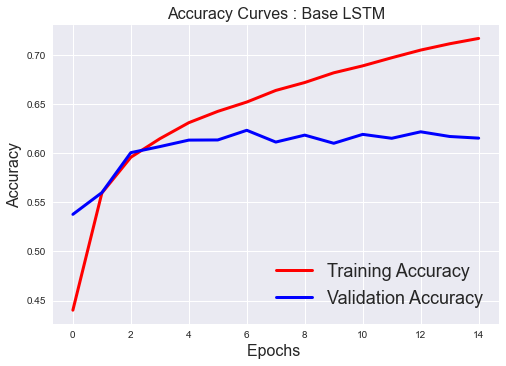

In [92]:
plot_loss_accuracy(lstm_history_base_model, 'Base LSTM')

In [35]:
_,val_acc = lstm_base_model.evaluate(train_dataset)

3659/3659 [==============================] - 68s 19ms/step - loss: 0.7957 - acc: 0.6750


In [36]:
hist_1 = pd.DataFrame(lstm_history_base_model.history)
hist_1['epoch'] = lstm_history_base_model.epoch

In [37]:
hist_1

,loss,acc,val_loss,val_acc,epoch
0,1.196290,0.453727,1.074044,0.524908,0
1,1.014022,0.566224,0.991917,0.583795,1
2,0.955960,0.599429,1.000997,0.573801,2
3,0.919800,0.617262,0.949865,0.603321,3
4,0.890626,0.630244,0.931217,0.612085,4
5,0.866337,0.642628,0.927732,0.618235,5
6,0.848021,0.650707,0.922312,0.617159,6
7,0.827361,0.662083,0.920632,0.623309,7
8,0.806138,0.671871,0.924501,0.623155,8
9,0.787073,0.680941,0.951537,0.612854,9


In [39]:
lstm_base_model.predict([''' 
It seems you're having some trouble In dealing with these changes Living with these changes (oh no) 
The world is a scary place Now that you've woken up the demon in me 
Why can't you just leave here and die Never stick your hand in my face again bitch
Fuck you
I don't need this shit

''' ])


1/1 [==============================] - 1s 610ms/step


array([[0.01462658, 0.6735971 , 0.0838844 , 0.22789197]], dtype=float32)

In [40]:
train_dataset.class_names

['Jazz', 'Metal', 'Pop', 'Rock']

In [112]:
lstm_base_model.predict(test_dataset)

250/250 [==============================] - 21s 78ms/step


array([[8.47213209e-01, 1.59461203e-03, 4.54919077e-02, 1.05700254e-01],
       [2.83555570e-03, 4.48148131e-01, 5.15938759e-01, 3.30775902e-02],
       [1.04240198e-02, 4.39957589e-01, 1.39195517e-01, 4.10422921e-01],
       ...,
       [9.80169512e-03, 5.39947152e-01, 1.15816474e-01, 3.34434688e-01],
       [4.14369881e-01, 6.90737972e-03, 2.98994154e-01, 2.79728621e-01],
       [2.07361692e-04, 9.80382085e-01, 3.42025119e-03, 1.59902852e-02]],
      dtype=float32)

## Optimize base LSTM

In [47]:
tf.keras.backend.clear_session()

In [93]:
model_name = "optimized lstm model"
checkpointer_opt = ModelCheckpoint(filepath =check_point_opt,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping_opt = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [94]:
lstm_opt_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  LSTM(128,return_sequences=True,dropout=0.2),
  tf.keras.layers.GlobalMaxPooling1D(),
  Dense(64,activation='relu'),
  Dense(N_CLASSES,activation = softmax)])

lstm_opt_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = Adam(),
    metrics = ["acc"]
    )

In [95]:
lstm_opt_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 200, 100)          500200    
                                                                 
 lstm_2 (LSTM)               (None, 200, 128)          117248    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                

In [96]:
lstm_history_opt_model = lstm_opt_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 15,
          callbacks=[checkpointer_opt, early_stopping_opt])

Epoch 1/15
3659/3659 [==============================] - ETA: 0s - loss: 1.0075 - acc: 0.5665

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


3659/3659 [==============================] - 548s 149ms/step - loss: 1.0075 - acc: 0.5665 - val_loss: 0.9562 - val_acc: 0.6042
Epoch 2/15
3659/3659 [==============================] - ETA: 0s - loss: 0.9165 - acc: 0.6156

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


3659/3659 [==============================] - 516s 141ms/step - loss: 0.9165 - acc: 0.6156 - val_loss: 0.8993 - val_acc: 0.6270
Epoch 3/15
3659/3659 [==============================] - ETA: 0s - loss: 0.8791 - acc: 0.6326

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


3659/3659 [==============================] - 478s 131ms/step - loss: 0.8791 - acc: 0.6326 - val_loss: 0.8815 - val_acc: 0.6407
Epoch 4/15
3659/3659 [==============================] - ETA: 0s - loss: 0.8511 - acc: 0.6478

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


3659/3659 [==============================] - 505s 138ms/step - loss: 0.8511 - acc: 0.6478 - val_loss: 0.8684 - val_acc: 0.6445
Epoch 5/15
3659/3659 [==============================] - ETA: 0s - loss: 0.8304 - acc: 0.6574

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


3659/3659 [==============================] - 493s 135ms/step - loss: 0.8304 - acc: 0.6574 - val_loss: 0.8833 - val_acc: 0.6370
Epoch 6/15
3659/3659 [==============================] - ETA: 0s - loss: 0.8135 - acc: 0.6654

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


3659/3659 [==============================] - 503s 138ms/step - loss: 0.8135 - acc: 0.6654 - val_loss: 0.8794 - val_acc: 0.6442
Epoch 7/15
3659/3659 [==============================] - ETA: 0s - loss: 0.7976 - acc: 0.6723

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


3659/3659 [==============================] - 509s 139ms/step - loss: 0.7976 - acc: 0.6723 - val_loss: 0.8808 - val_acc: 0.6404
Epoch 8/15
3659/3659 [==============================] - ETA: 0s - loss: 0.7853 - acc: 0.6774

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


3659/3659 [==============================] - 504s 138ms/step - loss: 0.7853 - acc: 0.6774 - val_loss: 0.8790 - val_acc: 0.6408
Epoch 9/15
3659/3659 [==============================] - ETA: 0s - loss: 0.7715 - acc: 0.6847

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


3659/3659 [==============================] - 513s 140ms/step - loss: 0.7715 - acc: 0.6847 - val_loss: 0.8725 - val_acc: 0.6542
Epoch 10/15
3659/3659 [==============================] - ETA: 0s - loss: 0.7579 - acc: 0.6899

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


3659/3659 [==============================] - 503s 138ms/step - loss: 0.7579 - acc: 0.6899 - val_loss: 0.8709 - val_acc: 0.6499
Epoch 11/15
3659/3659 [==============================] - ETA: 0s - loss: 0.7458 - acc: 0.6939

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


3659/3659 [==============================] - 523s 143ms/step - loss: 0.7458 - acc: 0.6939 - val_loss: 0.8753 - val_acc: 0.6548
Epoch 12/15
3659/3659 [==============================] - ETA: 0s - loss: 0.7382 - acc: 0.6987

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


3659/3659 [==============================] - 531s 145ms/step - loss: 0.7382 - acc: 0.6987 - val_loss: 0.8855 - val_acc: 0.6508
Epoch 13/15
3659/3659 [==============================] - ETA: 0s - loss: 0.7470 - acc: 0.6943

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


3659/3659 [==============================] - 524s 143ms/step - loss: 0.7470 - acc: 0.6943 - val_loss: 0.8928 - val_acc: 0.6439
Epoch 14/15
3659/3659 [==============================] - ETA: 0s - loss: 0.7212 - acc: 0.7055

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


3659/3659 [==============================] - 512s 140ms/step - loss: 0.7212 - acc: 0.7055 - val_loss: 0.8935 - val_acc: 0.6435


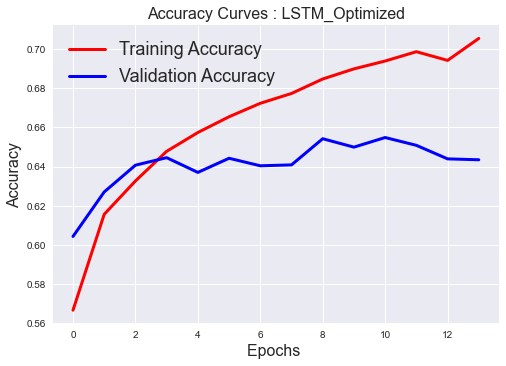

In [97]:
plot_loss_accuracy(lstm_history_opt_model, 'LSTM_Optimized')

In [132]:
_,val_acc = lstm_opt_model.evaluate(val_dataset)

407/407 [==============================] - 28s 67ms/step - loss: 0.8935 - acc: 0.6435


In [98]:
hist_2 = pd.DataFrame(lstm_history_opt_model.history)
hist_2['epoch'] = lstm_history_opt_model.epoch

In [107]:
hist_2

,loss,acc,val_loss,val_acc,epoch
0,1.007455,0.566531,0.956178,0.604244,0
1,0.916492,0.615571,0.899266,0.626999,1
2,0.879054,0.632618,0.881452,0.640683,2
3,0.851090,0.647769,0.868361,0.644526,3
4,0.830392,0.657386,0.883321,0.636993,4
5,0.813452,0.665448,0.879414,0.644219,5
6,0.797604,0.672332,0.880825,0.640375,6
7,0.785258,0.677354,0.878960,0.640836,7
8,0.771479,0.684750,0.872527,0.654213,8
9,0.757875,0.689926,0.870941,0.649908,9


## Bidirectional LSTM

In [106]:
tf.keras.backend.clear_session()

In [108]:
lstm_bi_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  Bidirectional(LSTM(128)),
  
  Dense(N_CLASSES, activation = softmax)
  ])

lstm_bi_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = Adam(),
    metrics = ["acc"]
    )

In [109]:
lstm_bi_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 100)          500200    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 1028      
                                                                 
Total params: 735,724
Trainable params: 235,524
Non-trainable params: 500,200
_________________________________________________________________


In [110]:
lstm_history_bi_model = lstm_bi_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 15,
          verbose = 1)

Epoch 1/15
3659/3659 [==============================] - 1015s 276ms/step - loss: 1.0574 - acc: 0.5476 - val_loss: 0.9817 - val_acc: 0.5789
Epoch 2/15
3659/3659 [==============================] - 968s 265ms/step - loss: 0.9463 - acc: 0.6032 - val_loss: 0.9455 - val_acc: 0.6050
Epoch 3/15
3659/3659 [==============================] - 956s 261ms/step - loss: 0.8909 - acc: 0.6277 - val_loss: 0.9259 - val_acc: 0.6150
Epoch 4/15
3659/3659 [==============================] - 981s 268ms/step - loss: 0.8427 - acc: 0.6517 - val_loss: 0.9375 - val_acc: 0.6173
Epoch 5/15
3659/3659 [==============================] - 993s 271ms/step - loss: 0.7877 - acc: 0.6770 - val_loss: 0.9384 - val_acc: 0.6164
Epoch 6/15
3659/3659 [==============================] - 998s 273ms/step - loss: 0.7312 - acc: 0.7016 - val_loss: 0.9655 - val_acc: 0.6127
Epoch 7/15
3659/3659 [==============================] - 1033s 282ms/step - loss: 0.6703 - acc: 0.7271 - val_loss: 1.0014 - val_acc: 0.6056
Epoch 8/15
3659/3659 [==========

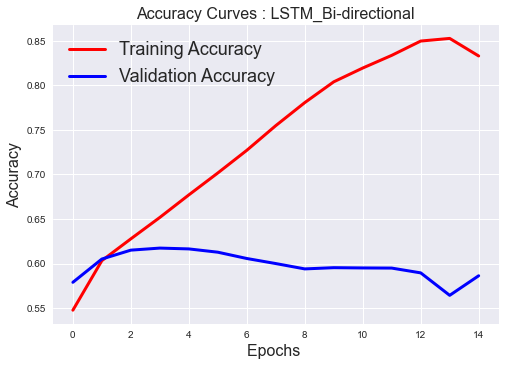

In [111]:
plot_loss_accuracy(lstm_history_bi_model, 'LSTM_Bi-directional')

In [127]:
_,val_acc = lstm_bi_model.evaluate(val_dataset)

407/407 [==============================] - 48s 118ms/step - loss: 1.4634 - acc: 0.5863


In [71]:
hist_3 = pd.DataFrame(lstm_history_bi_model.history)
hist_3['epoch'] = lstm_history_bi_model.epoch

In [68]:
hist_3

,loss,acc,val_loss,val_acc,epoch
0,1.080597,0.531566,1.005716,0.568573,0
1,0.987166,0.579957,0.992043,0.573801,1
2,0.963187,0.592614,0.989545,0.585486,2
3,0.944030,0.601445,1.013168,0.580873,3
4,0.934162,0.603409,0.986549,0.585793,4
5,0.926191,0.607885,1.002506,0.585486,5
6,0.913488,0.612958,0.992928,0.583795,6
7,0.908020,0.614410,0.989727,0.582565,7
8,0.902366,0.620474,0.984594,0.589330,8
9,0.901851,0.619739,0.974403,0.592866,9


Model is overfitting and validation accuracy is not only not improving, but decreasing with each epoch.

## Denser Bi-directional LSTM

In [ ]:
model_name = "cnn model"
checkpointer_cnn = ModelCheckpoint(filepath =check_point_cnn,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping_cnn = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [74]:
lstm_bi_opt_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  Bidirectional(LSTM(64, return_sequences = True)),
  Bidirectional(LSTM(64)),
  
  Dense(N_CLASSES, activation = softmax)
  ])

lstm_bi_opt_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate = LEARNING_RATE),
    metrics = ["acc"]
    )

In [75]:
lstm_bi_opt_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 200, 100)          500200    
                                                                 
 bidirectional_3 (Bidirectio  (None, 200, 128)         84480     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                      

In [76]:
lstm_history_bi__opt_model = lstm_bi_opt_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 10,
          verbose = 1)

Epoch 1/10
3659/3659 [==============================] - 670s 181ms/step - loss: 1.0620 - acc: 0.5386 - val_loss: 0.9877 - val_acc: 0.5812
Epoch 2/10
3659/3659 [==============================] - 654s 179ms/step - loss: 0.9602 - acc: 0.5946 - val_loss: 0.9550 - val_acc: 0.6095
Epoch 3/10
3659/3659 [==============================] - 658s 180ms/step - loss: 0.9284 - acc: 0.6112 - val_loss: 0.9383 - val_acc: 0.6196
Epoch 4/10
3659/3659 [==============================] - 658s 180ms/step - loss: 0.9231 - acc: 0.6080 - val_loss: 0.9696 - val_acc: 0.5878
Epoch 5/10
3659/3659 [==============================] - 662s 181ms/step - loss: 0.9103 - acc: 0.6163 - val_loss: 0.9418 - val_acc: 0.6109
Epoch 6/10
3659/3659 [==============================] - 666s 182ms/step - loss: 0.8921 - acc: 0.6274 - val_loss: 0.9565 - val_acc: 0.6027
Epoch 7/10
3659/3659 [==============================] - 665s 182ms/step - loss: 0.8798 - acc: 0.6328 - val_loss: 0.9397 - val_acc: 0.6105
Epoch 8/10
3659/3659 [============

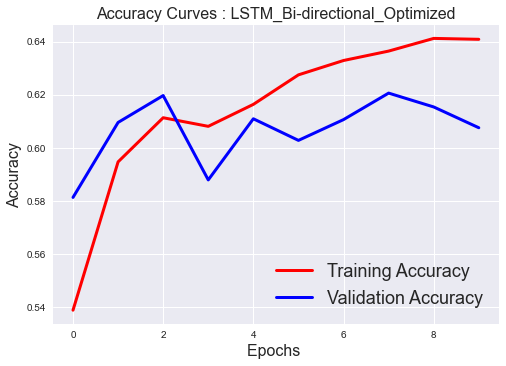

In [78]:
plot_loss_accuracy(lstm_history_bi__opt_model, 'LSTM_Bi-directional_Optimized')

In [83]:
lstm_history_bi__opt_model

In [131]:
_,val_acc = lstm_bi_opt_model.evaluate(val_dataset)

407/407 [==============================] - 42s 101ms/step - loss: 0.9559 - acc: 0.6075


In [129]:
hist_4 = pd.DataFrame(lstm_history_bi__opt_model.history)
hist_4['epoch'] = lstm_history_bi__opt_model.epoch

In [85]:
hist_4

,loss,acc,val_loss,val_acc,epoch
0,1.062027,0.538638,0.987721,0.581181,0
1,0.960216,0.594595,0.955040,0.609471,1
2,0.928389,0.611250,0.938325,0.619619,2
3,0.923080,0.608004,0.969586,0.587792,3
4,0.910301,0.616289,0.941787,0.610855,4
5,0.892118,0.627426,0.956469,0.602706,5
6,0.879768,0.632840,0.939721,0.610547,6
7,0.871982,0.636393,0.935247,0.620541,7
8,0.862482,0.641176,0.941177,0.615314,8
9,0.861530,0.640834,0.955860,0.607472,9


## CNN model

In [119]:
tf.keras.backend.clear_session()

checkpointer_cnn = ModelCheckpoint(filepath =check_point_cnn,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping_cnn = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [122]:
cnn_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  Conv1D(128,3, padding = 'same', activation= 'relu'),
  MaxPool1D(),
 
  
  Conv1D(128,5, padding = 'same', activation= 'relu'),
  MaxPool1D(),
  Dropout(0.2),
  
  
  Conv1D(128,5, padding = 'same', activation= 'relu'),
  MaxPool1D(),
  Dropout(0.2),
  
  
  Flatten(),
  Dense(128, activation = 'relu'),
  Dense(N_CLASSES, activation = softmax)
  ])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate = LEARNING_RATE),
    metrics = ["acc"]
    )

In [117]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 200, 100)          500200    
                                                                 
 conv1d_3 (Conv1D)           (None, 200, 128)          38528     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 100, 128)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 128)          82048     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 50, 128)          0

In [123]:
cnn_history_model = cnn_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 10,
          callbacks=[checkpointer_cnn, early_stopping_cnn])

Epoch 1/10
3659/3659 [==============================] - ETA: 0s - loss: 1.0431 - acc: 0.5499

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


3659/3659 [==============================] - 159s 43ms/step - loss: 1.0431 - acc: 0.5499 - val_loss: 0.9983 - val_acc: 0.5809
Epoch 2/10
3659/3659 [==============================] - ETA: 0s - loss: 0.9389 - acc: 0.6068

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


3659/3659 [==============================] - 158s 43ms/step - loss: 0.9389 - acc: 0.6068 - val_loss: 0.9486 - val_acc: 0.6092
Epoch 3/10
3659/3659 [==============================] - ETA: 0s - loss: 0.8851 - acc: 0.6321

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


3659/3659 [==============================] - 155s 42ms/step - loss: 0.8851 - acc: 0.6321 - val_loss: 0.9361 - val_acc: 0.6145
Epoch 4/10
3658/3659 [============================>.] - ETA: 0s - loss: 0.8448 - acc: 0.6505

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


3659/3659 [==============================] - 152s 42ms/step - loss: 0.8449 - acc: 0.6504 - val_loss: 0.9317 - val_acc: 0.6212
Epoch 5/10
3659/3659 [==============================] - ETA: 0s - loss: 0.8038 - acc: 0.6690

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


3659/3659 [==============================] - 154s 42ms/step - loss: 0.8038 - acc: 0.6690 - val_loss: 0.9433 - val_acc: 0.6098
Epoch 6/10
3658/3659 [============================>.] - ETA: 0s - loss: 0.7689 - acc: 0.6842

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


3659/3659 [==============================] - 155s 42ms/step - loss: 0.7689 - acc: 0.6842 - val_loss: 0.9611 - val_acc: 0.6113
Epoch 7/10
3658/3659 [============================>.] - ETA: 0s - loss: 0.7365 - acc: 0.6965

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


3659/3659 [==============================] - 156s 43ms/step - loss: 0.7365 - acc: 0.6965 - val_loss: 0.9571 - val_acc: 0.6125
Epoch 8/10
3658/3659 [============================>.] - ETA: 0s - loss: 0.7093 - acc: 0.7092

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


3659/3659 [==============================] - 157s 43ms/step - loss: 0.7093 - acc: 0.7092 - val_loss: 0.9716 - val_acc: 0.6145
Epoch 9/10
3658/3659 [============================>.] - ETA: 0s - loss: 0.6775 - acc: 0.7213

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


3659/3659 [==============================] - 157s 43ms/step - loss: 0.6775 - acc: 0.7213 - val_loss: 0.9898 - val_acc: 0.6167
Epoch 10/10
3658/3659 [============================>.] - ETA: 0s - loss: 0.6563 - acc: 0.7304

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


3659/3659 [==============================] - 163s 45ms/step - loss: 0.6563 - acc: 0.7304 - val_loss: 1.0292 - val_acc: 0.6069


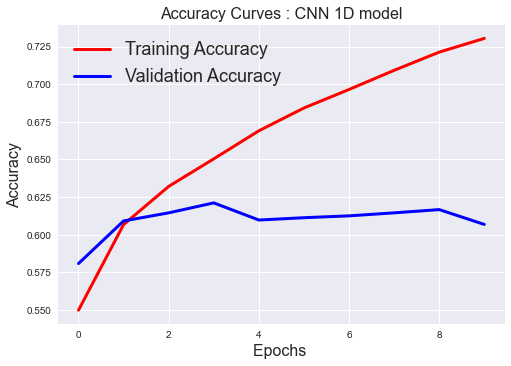

In [124]:
plot_loss_accuracy(cnn_history_model, 'CNN 1D model')

In [125]:
hist_5 = pd.DataFrame(cnn_history_model.history)
hist_5['epoch'] = cnn_history_model.epoch

In [126]:
hist_5

,loss,acc,val_loss,val_acc,epoch
0,1.043131,0.549894,0.998291,0.580873,0
1,0.938856,0.606774,0.948648,0.609164,1
2,0.885051,0.632089,0.936069,0.614545,2
3,0.844941,0.650400,0.931686,0.621156,3
4,0.803813,0.669018,0.943325,0.609779,4
5,0.768901,0.684169,0.961147,0.611316,5
6,0.736468,0.696468,0.957059,0.612546,6
7,0.709331,0.709176,0.971575,0.614545,7
8,0.677503,0.721269,0.989773,0.616697,8
9,0.656306,0.730374,1.029151,0.606857,9
